# PHM 데이터셋 고장 분류 - 답안 노트북

이 노트북은 CNN-LSTM 모델을 사용하여 장비 고장 유형을 분류하는 완전한 구현 예시입니다.

## 목표
- 시계열 센서 데이터 전처리
- 슬라이딩 윈도우 기법 구현
- CNN-LSTM 하이브리드 모델 구축
- 고장 분류 모델 학습 및 평가

## 1. 라이브러리 Import

In [2]:
# 기본 라이브러리
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# 전처리
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

# 딥러닝
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# 시드 고정 (재현성)
np.random.seed(42)
tf.random.set_seed(42)

# 시각화 스타일 설정
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.13.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 2. 합성 데이터 생성

실제 PHM 데이터셋이 없는 경우를 대비한 합성 데이터 생성

**Note**: 실제 프로젝트에서는 PHM Society Data Challenge에서 제공하는 실제 데이터를 사용하세요.

In [3]:
def generate_synthetic_data(n_samples=10000, n_sensors=10, n_fault_types=4, add_noise=True):
    """
    합성 PHM 센서 데이터 생성
    
    각 고장 유형은 고유한 패턴을 가지도록 설계:
    - Type 0 (Normal): 정상 범위의 작은 변동
    - Type 1 (Fault 1): 평균이 증가하는 패턴
    - Type 2 (Fault 2): 분산이 증가하는 패턴
    - Type 3 (Fault 3): 주기적 진동이 추가된 패턴
    
    실제 사용 시: PHM Society Data Challenge에서 제공하는 실제 PHM 데이터를 사용하세요.
    """
    
    data = []
    
    for i in range(n_samples):
        # 고장 유형 무작위 선택
        fault_type = np.random.randint(0, n_fault_types)
        
        # 기본 센서 데이터 생성
        if fault_type == 0:  # Normal
            # 정상: 평균 0, 표준편차 1의 정규분포
            sensor_data = np.random.normal(0, 1, n_sensors)
            
        elif fault_type == 1:  # Fault Type 1 - 평균 증가
            # 평균이 높은 데이터 (평균 shift)
            sensor_data = np.random.normal(3, 1.5, n_sensors)
            
        elif fault_type == 2:  # Fault Type 2 - 분산 증가
            # 높은 분산
            sensor_data = np.random.normal(0, 3, n_sensors)
            
        else:  # Fault Type 3 - 주기적 패턴
            # 정현파 패턴 추가
            base = np.random.normal(0, 1, n_sensors)
            sine_wave = 2 * np.sin(np.linspace(0, 2*np.pi, n_sensors))
            sensor_data = base + sine_wave
        
        # 노이즈 추가 (선택적)
        if add_noise:
            noise = np.random.normal(0, 0.1, n_sensors)
            sensor_data += noise
        
        # 데이터 저장
        row = list(sensor_data) + [fault_type]
        data.append(row)
    
    # 데이터프레임 생성
    columns = [f'sensor_{i+1}' for i in range(n_sensors)] + ['fault_type']
    df = pd.DataFrame(data, columns=columns)
    
    return df

# 합성 데이터 생성
print("합성 PHM 데이터 생성 중...")
df = generate_synthetic_data(n_samples=10000, n_sensors=10, n_fault_types=4)

# 실제 PHM 데이터를 사용하는 경우 아래 주석 해제:
# df = pd.read_csv('../data/raw/phm_data.csv')
# PHM Society Data Challenge에서 다운로드한 데이터를 사용하세요

print(f"\n데이터 shape: {df.shape}")
print(f"\n고장 유형 분포:")
print(df['fault_type'].value_counts().sort_index())
print(f"\n데이터 샘플:")
print(df.head())

합성 PHM 데이터 생성 중...

데이터 shape: (10000, 11)

고장 유형 분포:
fault_type
0    2468
1    2503
2    2534
3    2495
Name: count, dtype: int64

데이터 샘플:
   sensor_1  sensor_2  sensor_3  sensor_4  sensor_5  sensor_6  sensor_7  \
0 -1.642720  1.530348  1.423805  4.062571 -2.803662 -0.384189 -6.010681   
1  0.099274 -0.476501 -0.726766  1.056639  0.568865 -0.516196 -0.999688   
2  6.558724  4.736844  3.165783  3.688358  1.480825  1.416995  0.333379   
3  2.900690  4.475399  3.551630  1.833563  3.520126  5.342766  3.094050   
4  0.773730  4.385040  2.707175  1.465073  2.390554  0.776944  2.678391   

   sensor_8  sensor_9  sensor_10  fault_type  
0 -1.555208  1.191986  -2.791019           2  
1 -0.073579 -0.634557  -0.163857           0  
2  0.837437  4.049458   1.812571           1  
3  5.295138 -1.010467   4.182678           1  
4  4.110845  2.417864   1.625868           1  


## 3. 데이터 탐색 (EDA)

In [4]:
# 기본 통계 정보
print("데이터 기본 정보:")
print(df.info())
print("\n기술 통계량:")
print(df.describe())

데이터 기본 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   sensor_1    10000 non-null  float64
 1   sensor_2    10000 non-null  float64
 2   sensor_3    10000 non-null  float64
 3   sensor_4    10000 non-null  float64
 4   sensor_5    10000 non-null  float64
 5   sensor_6    10000 non-null  float64
 6   sensor_7    10000 non-null  float64
 7   sensor_8    10000 non-null  float64
 8   sensor_9    10000 non-null  float64
 9   sensor_10   10000 non-null  float64
 10  fault_type  10000 non-null  int64  
dtypes: float64(10), int64(1)
memory usage: 859.5 KB
None

기술 통계량:
           sensor_1      sensor_2      sensor_3      sensor_4      sensor_5  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean       0.774210      1.061641      1.244918      1.195440      0.932324   
std        2.275584      2.218224      2.262

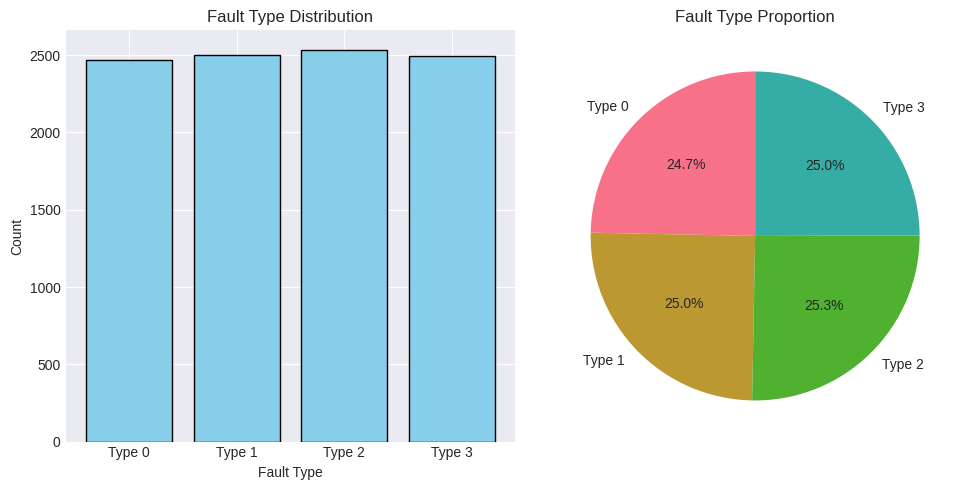

In [5]:
# 고장 유형 분포 시각화
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
fault_counts = df['fault_type'].value_counts().sort_index()
plt.bar(fault_counts.index, fault_counts.values, color='skyblue', edgecolor='black')
plt.xlabel('Fault Type')
plt.ylabel('Count')
plt.title('Fault Type Distribution')
plt.xticks(fault_counts.index, [f'Type {i}' for i in fault_counts.index])

plt.subplot(1, 2, 2)
plt.pie(fault_counts.values, labels=[f'Type {i}' for i in fault_counts.index], 
        autopct='%1.1f%%', startangle=90)
plt.title('Fault Type Proportion')

plt.tight_layout()
plt.show()

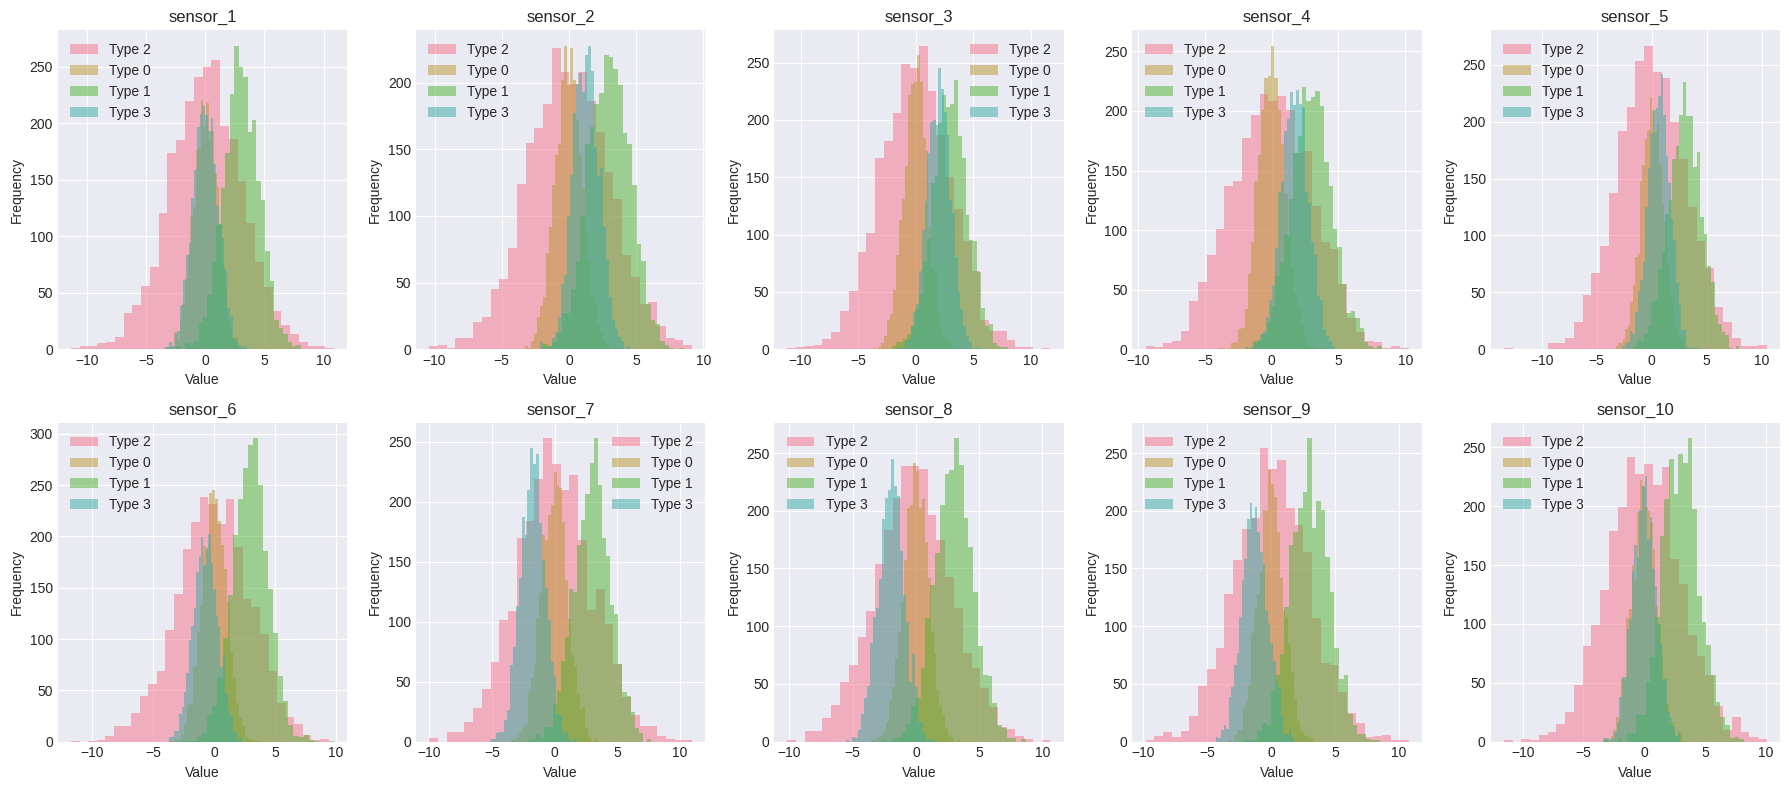

In [6]:
# 센서 데이터 분포 비교 (고장 유형별)
fig, axes = plt.subplots(2, 5, figsize=(18, 8))
axes = axes.ravel()

sensor_cols = [col for col in df.columns if 'sensor' in col]

for idx, sensor in enumerate(sensor_cols):
    for fault_type in df['fault_type'].unique():
        data = df[df['fault_type'] == fault_type][sensor]
        axes[idx].hist(data, alpha=0.5, label=f'Type {fault_type}', bins=30)
    
    axes[idx].set_title(sensor)
    axes[idx].set_xlabel('Value')
    axes[idx].set_ylabel('Frequency')
    axes[idx].legend()

plt.tight_layout()
plt.show()

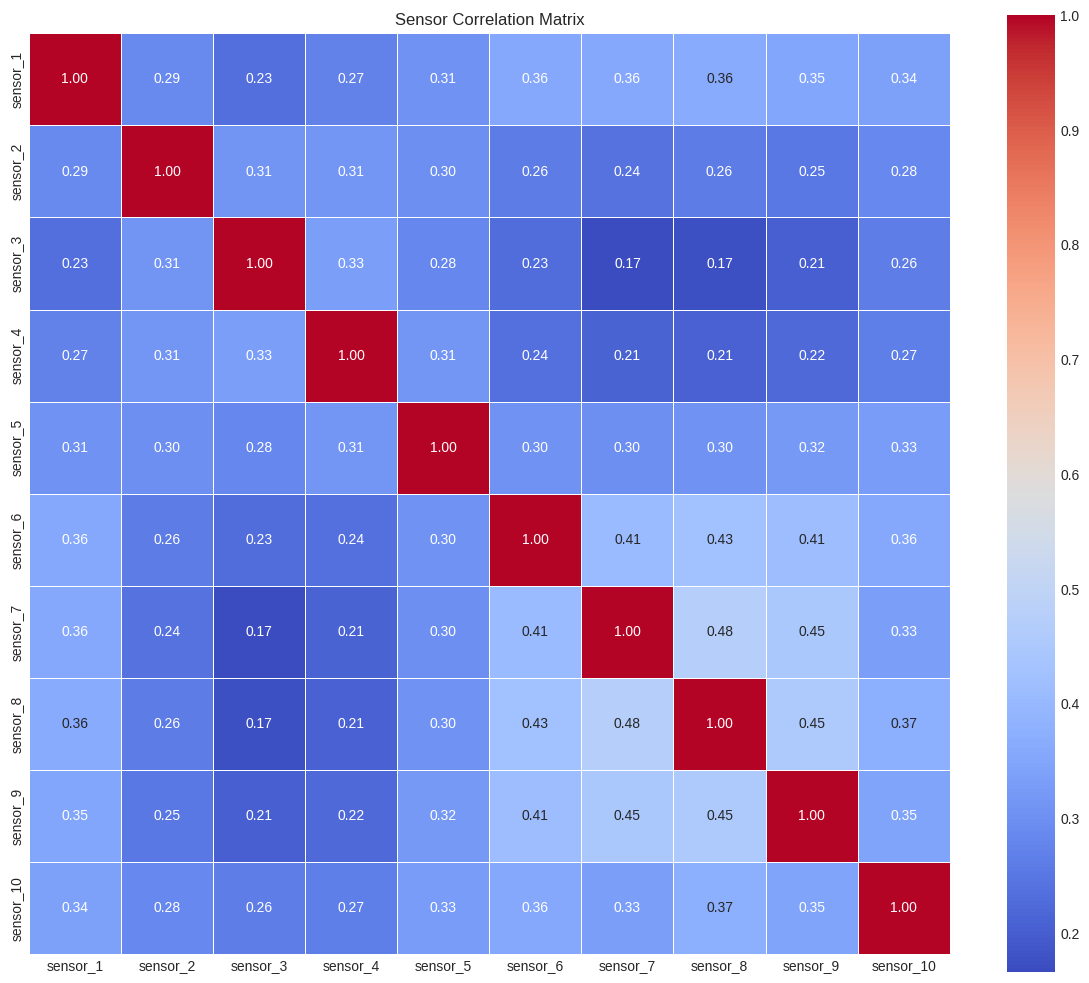

In [7]:
# 센서 간 상관관계 분석
plt.figure(figsize=(12, 10))
correlation_matrix = df[sensor_cols].corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            square=True, linewidths=0.5)
plt.title('Sensor Correlation Matrix')
plt.tight_layout()
plt.show()

## 4. 데이터 전처리

### 4.1 특징(X)과 타겟(y) 분리

In [8]:
# 센서 데이터와 레이블 분리
X = df.drop('fault_type', axis=1).values
y = df['fault_type'].values

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"\n고장 유형 개수: {len(np.unique(y))}")
print(f"센서 개수: {X.shape[1]}")

X shape: (10000, 10)
y shape: (10000,)

고장 유형 개수: 4
센서 개수: 10


### 4.2 데이터 정규화

StandardScaler를 사용하여 평균 0, 분산 1로 정규화

정규화 전:
  평균: 0.7520, 표준편차: 2.3494

정규화 후:
  평균: 0.0000, 표준편차: 1.0000


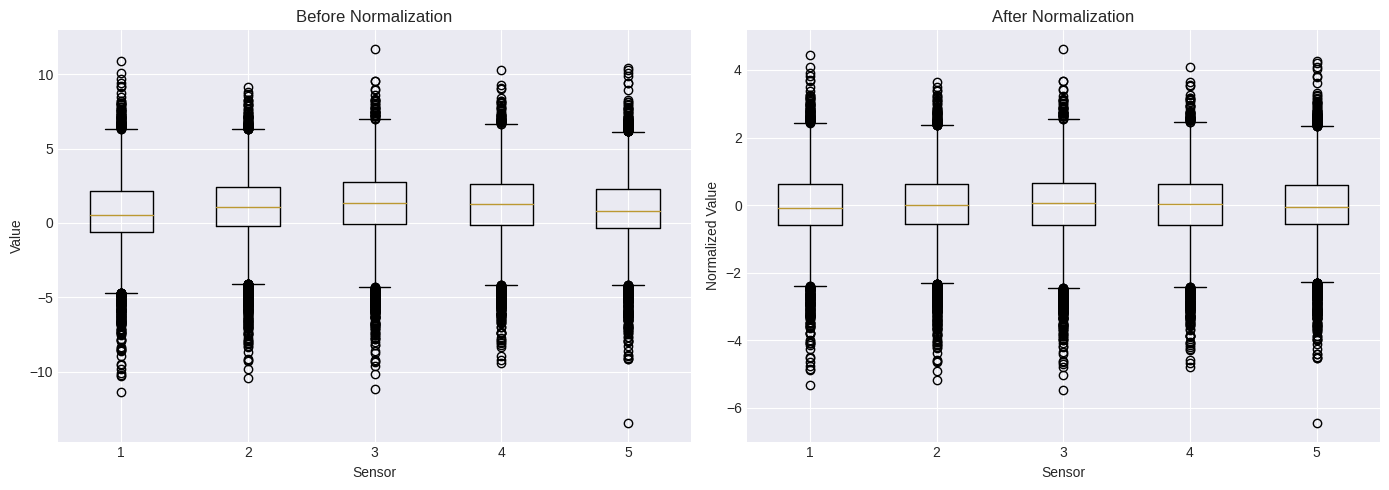

In [9]:
# StandardScaler를 사용한 정규화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"정규화 전:")
print(f"  평균: {X.mean():.4f}, 표준편차: {X.std():.4f}")
print(f"\n정규화 후:")
print(f"  평균: {X_scaled.mean():.4f}, 표준편차: {X_scaled.std():.4f}")

# 정규화 전후 비교 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].boxplot(X[:, :5])  # 처음 5개 센서만
axes[0].set_title('Before Normalization')
axes[0].set_xlabel('Sensor')
axes[0].set_ylabel('Value')

axes[1].boxplot(X_scaled[:, :5])
axes[1].set_title('After Normalization')
axes[1].set_xlabel('Sensor')
axes[1].set_ylabel('Normalized Value')

plt.tight_layout()
plt.show()

### 4.3 슬라이딩 윈도우 생성

시계열 데이터를 고정 길이의 윈도우로 변환

In [10]:
def create_sliding_windows(X, y, window_size=100, stride=50):
    """
    슬라이딩 윈도우를 사용하여 시계열 데이터를 변환
    
    Parameters:
    - X: 입력 데이터 (n_samples, n_features)
    - y: 레이블 (n_samples,)
    - window_size: 윈도우 크기
    - stride: 윈도우 이동 간격
    
    Returns:
    - X_windows: (n_windows, window_size, n_features)
    - y_windows: (n_windows,)
    """
    
    X_windows = []
    y_windows = []
    
    # stride 간격으로 윈도우 생성
    for i in range(0, len(X) - window_size + 1, stride):
        # 윈도우 추출
        window = X[i:i+window_size]
        # 윈도우의 마지막 시점 레이블 사용
        label = y[i+window_size-1]
        
        X_windows.append(window)
        y_windows.append(label)
    
    # numpy array로 변환
    X_windows = np.array(X_windows)
    y_windows = np.array(y_windows)
    
    return X_windows, y_windows

# 윈도우 파라미터 설정
window_size = 100
stride = 50

print(f"윈도우 설정:")
print(f"  Window Size: {window_size}")
print(f"  Stride: {stride}")

# 윈도우 생성
X_windows, y_windows = create_sliding_windows(X_scaled, y, window_size, stride)

print(f"\n원본 데이터 shape: {X_scaled.shape}")
print(f"윈도우 데이터 shape: {X_windows.shape}")
print(f"윈도우 레이블 shape: {y_windows.shape}")
print(f"\n생성된 윈도우 개수: {len(X_windows)}")

윈도우 설정:
  Window Size: 100
  Stride: 50

원본 데이터 shape: (10000, 10)
윈도우 데이터 shape: (199, 100, 10)
윈도우 레이블 shape: (199,)

생성된 윈도우 개수: 199


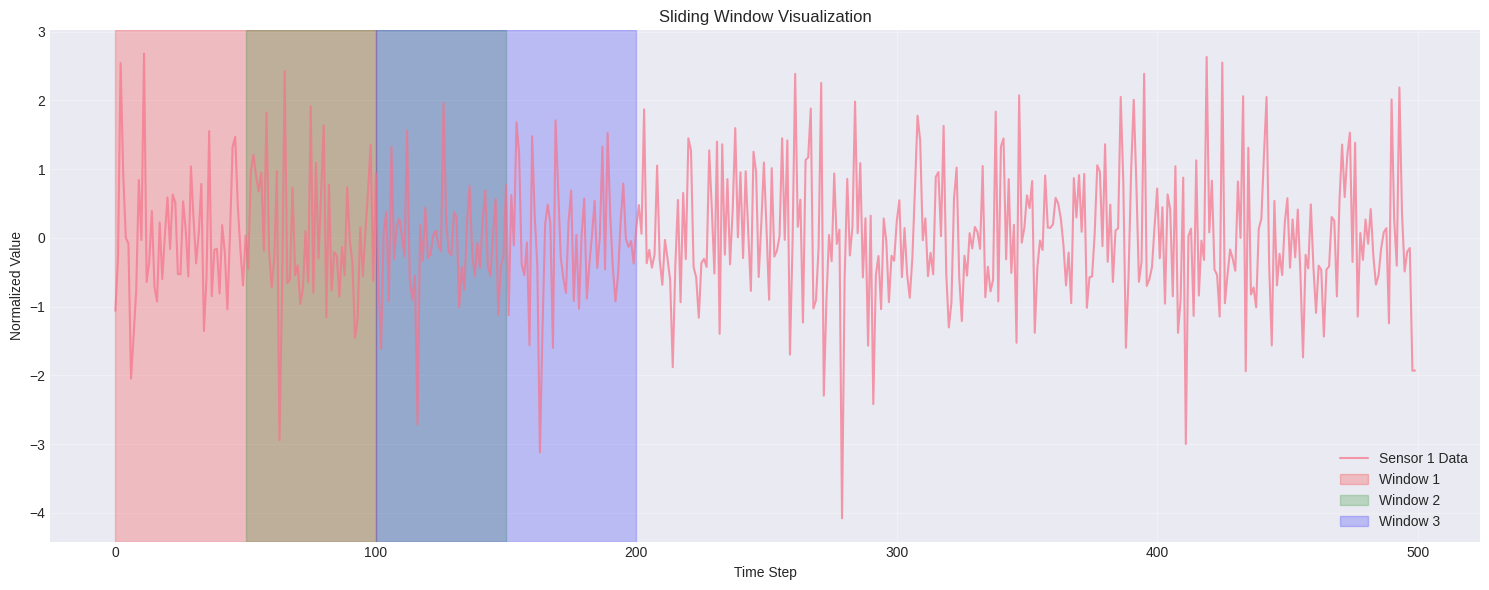

In [11]:
# 슬라이딩 윈도우 예시 시각화
plt.figure(figsize=(15, 6))

# 첫 번째 센서의 시계열 데이터와 윈도우 표시
sample_length = 500
plt.plot(X_scaled[:sample_length, 0], label='Sensor 1 Data', alpha=0.7)

# 처음 3개 윈도우 강조 표시
colors = ['red', 'green', 'blue']
for idx in range(3):
    start = idx * stride
    end = start + window_size
    if end <= sample_length:
        plt.axvspan(start, end, alpha=0.2, color=colors[idx], 
                   label=f'Window {idx+1}')

plt.xlabel('Time Step')
plt.ylabel('Normalized Value')
plt.title('Sliding Window Visualization')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 4.4 One-hot Encoding

In [12]:
# 레이블을 one-hot 벡터로 변환
y_categorical = to_categorical(y_windows)

print(f"원본 레이블 shape: {y_windows.shape}")
print(f"One-hot 레이블 shape: {y_categorical.shape}")
print(f"\n클래스 개수: {y_categorical.shape[1]}")

# 예시 출력
print(f"\n원본 레이블 예시: {y_windows[:5]}")
print(f"One-hot 레이블 예시:\n{y_categorical[:5]}")

원본 레이블 shape: (199,)
One-hot 레이블 shape: (199, 4)

클래스 개수: 4

원본 레이블 예시: [0 2 3 1 2]
One-hot 레이블 예시:
[[1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]]


### 4.5 Train/Test Split

In [13]:
# 학습/테스트 데이터 분리 (80:20)
X_train, X_test, y_train, y_test = train_test_split(
    X_windows, y_categorical, 
    test_size=0.2, 
    random_state=42,
    stratify=y_windows  # 계층적 샘플링으로 클래스 비율 유지
)

print(f"학습 데이터: {X_train.shape}, {y_train.shape}")
print(f"테스트 데이터: {X_test.shape}, {y_test.shape}")

# 클래스 분포 확인
print(f"\n학습 데이터 클래스 분포:")
print(pd.Series(np.argmax(y_train, axis=1)).value_counts().sort_index())
print(f"\n테스트 데이터 클래스 분포:")
print(pd.Series(np.argmax(y_test, axis=1)).value_counts().sort_index())

학습 데이터: (159, 100, 10), (159, 4)
테스트 데이터: (40, 100, 10), (40, 4)

학습 데이터 클래스 분포:
0    47
1    42
2    42
3    28
Name: count, dtype: int64

테스트 데이터 클래스 분포:
0    12
1    10
2    11
3     7
Name: count, dtype: int64


## 5. CNN-LSTM 모델 구축

In [14]:
def build_cnn_lstm_model(input_shape, n_classes):
    """
    CNN-LSTM 하이브리드 모델 구축
    
    아키텍처:
    1. Conv1D 레이어: 공간적 특징 추출 (센서 간 상관관계)
    2. MaxPooling: 차원 축소 및 중요 특징 강조
    3. LSTM 레이어: 시간적 의존성 학습
    4. Dense 레이어: 분류
    """
    
    model = models.Sequential(name='CNN_LSTM_Fault_Classifier')
    
    # CNN 블록 1
    model.add(layers.Conv1D(
        filters=64, 
        kernel_size=3, 
        activation='relu',
        padding='same',
        input_shape=input_shape,
        name='conv1d_1'
    ))
    model.add(layers.BatchNormalization(name='batch_norm_1'))
    model.add(layers.MaxPooling1D(pool_size=2, name='maxpool_1'))
    model.add(layers.Dropout(0.2, name='dropout_1'))
    
    # CNN 블록 2
    model.add(layers.Conv1D(
        filters=128, 
        kernel_size=3, 
        activation='relu',
        padding='same',
        name='conv1d_2'
    ))
    model.add(layers.BatchNormalization(name='batch_norm_2'))
    model.add(layers.MaxPooling1D(pool_size=2, name='maxpool_2'))
    model.add(layers.Dropout(0.2, name='dropout_2'))
    
    # LSTM 레이어
    model.add(layers.LSTM(
        units=100, 
        return_sequences=False,  # 마지막 타임스텝만 출력
        name='lstm'
    ))
    model.add(layers.Dropout(0.3, name='dropout_3'))
    
    # Dense 레이어
    model.add(layers.Dense(50, activation='relu', name='dense_1'))
    model.add(layers.Dropout(0.3, name='dropout_4'))
    
    # 출력 레이어
    model.add(layers.Dense(n_classes, activation='softmax', name='output'))
    
    return model

# 모델 생성
input_shape = (window_size, X_scaled.shape[1])  # (timesteps, features)
n_classes = y_categorical.shape[1]

print(f"Input shape: {input_shape}")
print(f"Number of classes: {n_classes}")

model = build_cnn_lstm_model(input_shape, n_classes)

# 모델 컴파일
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 모델 구조 출력
model.summary()

Input shape: (100, 10)
Number of classes: 4


2025-12-09 14:41:29.630587: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-12-09 14:41:29.630739: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-12-09 14:41:29.630826: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "CNN_LSTM_Fault_Classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 100, 64)           1984      
                                                                 
 batch_norm_1 (BatchNormali  (None, 100, 64)           256       
 zation)                                                         
                                                                 
 maxpool_1 (MaxPooling1D)    (None, 50, 64)            0         
                                                                 
 dropout_1 (Dropout)         (None, 50, 64)            0         
                                                                 
 conv1d_2 (Conv1D)           (None, 50, 128)           24704     
                                                                 
 batch_norm_2 (BatchNormali  (None, 50, 128)           512       
 zation)                                 

In [15]:
# 모델 아키텍처 시각화 (선택적)
try:
    keras.utils.plot_model(
        model, 
        to_file='../models/model_architecture.png',
        show_shapes=True,
        show_layer_names=True,
        rankdir='TB',  # Top to Bottom
        dpi=96
    )
    print("모델 아키텍처 이미지 저장 완료: ../models/model_architecture.png")
except:
    print("모델 시각화를 위해서는 graphviz와 pydot 설치가 필요합니다.")

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
모델 아키텍처 이미지 저장 완료: ../models/model_architecture.png


## 6. 모델 학습

In [16]:
# 콜백 설정
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    '../models/best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

callbacks = [early_stopping, model_checkpoint, reduce_lr]

print("학습 시작...\n")

학습 시작...



In [17]:
# 모델 학습
history = model.fit(
    X_train, y_train,
    validation_split=0.2,  # 학습 데이터의 20%를 검증에 사용
    epochs=50,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

print("\n학습 완료!")

Epoch 1/50


2025-12-09 14:41:33.968526: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8907
2025-12-09 14:41:34.183255: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2025-12-09 14:41:34.201800: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x74a880003b60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-09 14:41:34.201819: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2025-12-09 14:41:34.205483: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-09 14:41:34.279772: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the p

2/2 [==============================] - ETA: 0s - loss: 1.3889 - accuracy: 0.3307
Epoch 1: val_accuracy improved from -inf to 0.21875, saving model to ../models/best_model.h5
2/2 [==============================] - 3s 421ms/step - loss: 1.3889 - accuracy: 0.3307 - val_loss: 1.3821 - val_accuracy: 0.2188 - lr: 0.0010
Epoch 2/50
1/2 [==============>...............] - ETA: 0s - loss: 1.4385 - accuracy: 0.2031
Epoch 2: val_accuracy improved from 0.21875 to 0.37500, saving model to ../models/best_model.h5
2/2 [==============================] - 0s 40ms/step - loss: 1.3913 - accuracy: 0.2126 - val_loss: 1.3512 - val_accuracy: 0.3750 - lr: 0.0010
Epoch 3/50
1/2 [==============>...............] - ETA: 0s - loss: 1.3821 - accuracy: 0.2812
Epoch 3: val_accuracy did not improve from 0.37500
2/2 [==============================] - 0s 22ms/step - loss: 1.3609 - accuracy: 0.2913 - val_loss: 1.3336 - val_accuracy: 0.3750 - lr: 0.0010
Epoch 4/50
1/2 [==============>...............] - ETA: 0s - loss: 1.313

## 7. 학습 결과 시각화

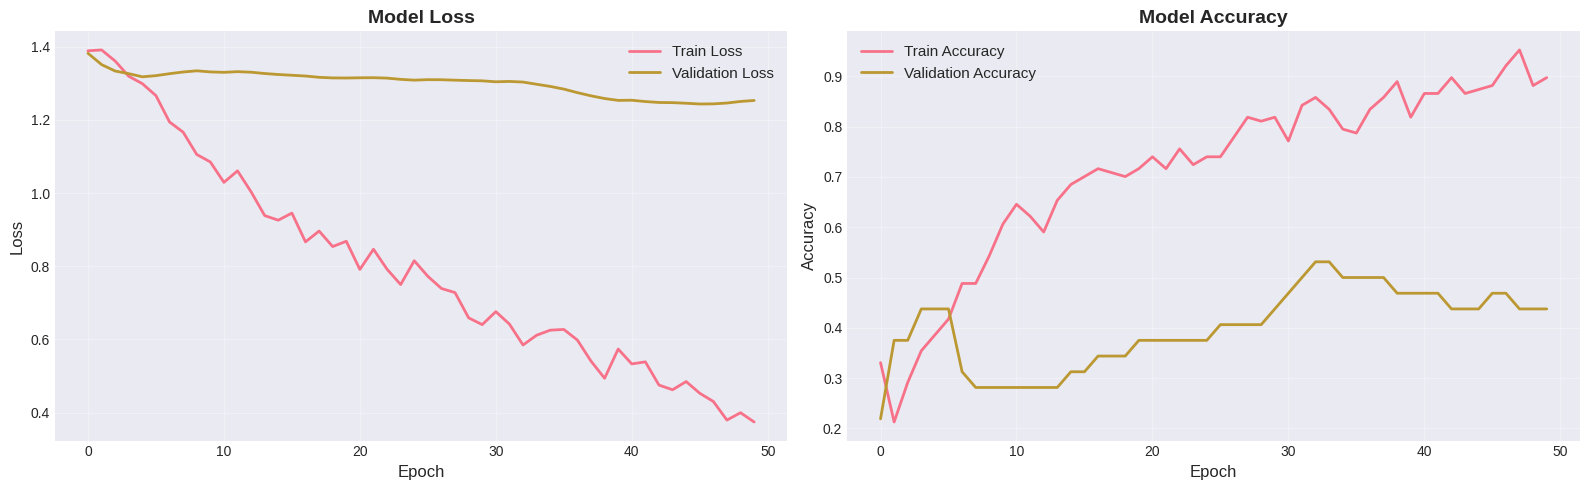


최고 검증 정확도: 0.5312 (Epoch 33)
최종 학습 정확도: 0.8976
최종 검증 정확도: 0.4375


In [18]:
# 학습 곡선 시각화
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Loss 곡선
axes[0].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Accuracy 곡선
axes[1].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../models/training_history.png', dpi=150, bbox_inches='tight')
plt.show()

# 최고 성능 출력
best_epoch = np.argmax(history.history['val_accuracy'])
print(f"\n최고 검증 정확도: {history.history['val_accuracy'][best_epoch]:.4f} (Epoch {best_epoch + 1})")
print(f"최종 학습 정확도: {history.history['accuracy'][-1]:.4f}")
print(f"최종 검증 정확도: {history.history['val_accuracy'][-1]:.4f}")

## 8. 모델 평가

In [19]:
# 테스트 데이터로 예측
print("테스트 데이터 평가 중...\n")

# 확률 예측
y_pred_prob = model.predict(X_test, verbose=0)

# 클래스 예측
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

# 정확도 계산
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"테스트 정확도: {accuracy:.4f}")
print(f"가중 F1-Score: {f1:.4f}")

테스트 데이터 평가 중...

테스트 정확도: 0.2750
가중 F1-Score: 0.2107


In [20]:
# Classification Report
print("\n" + "="*60)
print("Classification Report")
print("="*60)
target_names = [f'Fault Type {i}' for i in range(n_classes)]
print(classification_report(y_true, y_pred, target_names=target_names, digits=4))


Classification Report
              precision    recall  f1-score   support

Fault Type 0     0.0000    0.0000    0.0000        12
Fault Type 1     0.2917    0.7000    0.4118        10
Fault Type 2     0.3000    0.2727    0.2857        11
Fault Type 3     0.2000    0.1429    0.1667         7

    accuracy                         0.2750        40
   macro avg     0.1979    0.2789    0.2160        40
weighted avg     0.1904    0.2750    0.2107        40



### 8.1 Confusion Matrix 시각화

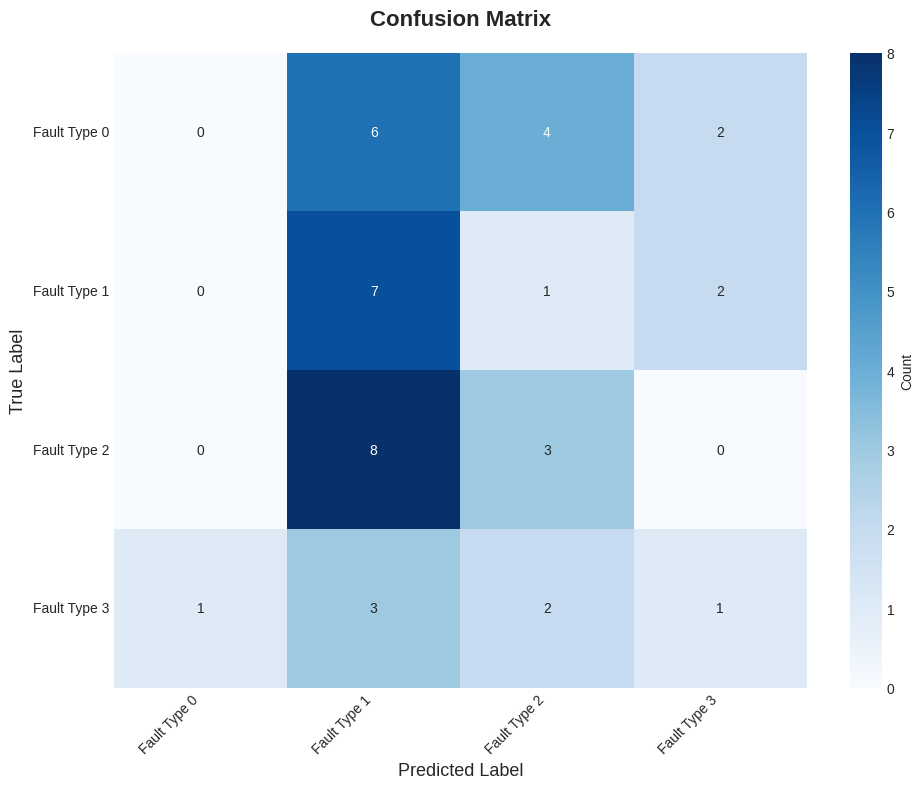

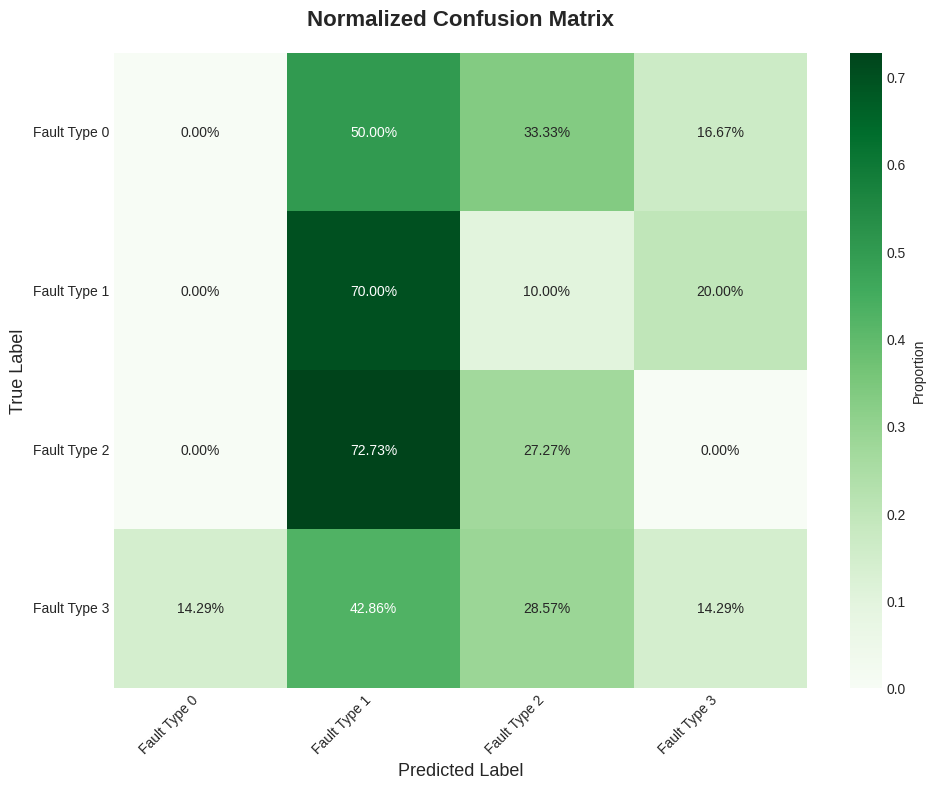

In [21]:
# Confusion Matrix 계산
cm = confusion_matrix(y_true, y_pred)

# 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names,
            yticklabels=target_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=13)
plt.xlabel('Predicted Label', fontsize=13)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('../models/confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

# 정규화된 Confusion Matrix (비율)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Greens',
            xticklabels=target_names,
            yticklabels=target_names,
            cbar_kws={'label': 'Proportion'})
plt.title('Normalized Confusion Matrix', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=13)
plt.xlabel('Predicted Label', fontsize=13)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('../models/confusion_matrix_normalized.png', dpi=150, bbox_inches='tight')
plt.show()

### 8.2 클래스별 성능 시각화


클래스별 성능 지표:
       Class  Precision   Recall  F1-Score  Support
Fault Type 0   0.000000 0.000000  0.000000       12
Fault Type 1   0.291667 0.700000  0.411765       10
Fault Type 2   0.300000 0.272727  0.285714       11
Fault Type 3   0.200000 0.142857  0.166667        7


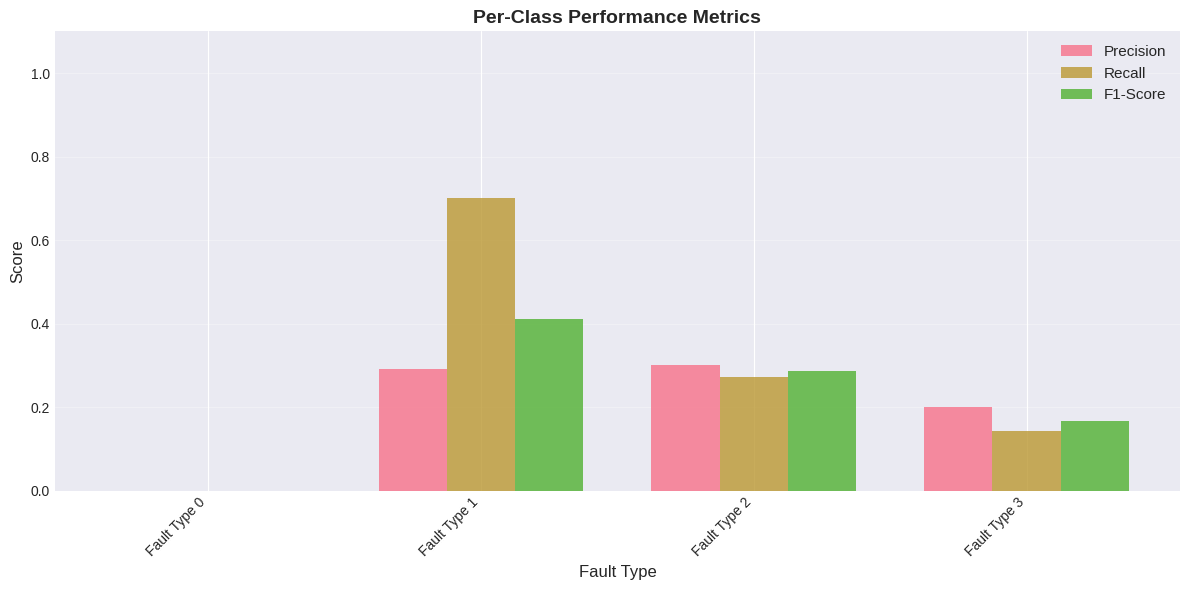

In [22]:
# 클래스별 Precision, Recall, F1-Score 시각화
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1_scores, support = precision_recall_fscore_support(y_true, y_pred)

# 데이터프레임 생성
metrics_df = pd.DataFrame({
    'Class': target_names,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1_scores,
    'Support': support
})

print("\n클래스별 성능 지표:")
print(metrics_df.to_string(index=False))

# 시각화
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(target_names))
width = 0.25

ax.bar(x - width, precision, width, label='Precision', alpha=0.8)
ax.bar(x, recall, width, label='Recall', alpha=0.8)
ax.bar(x + width, f1_scores, width, label='F1-Score', alpha=0.8)

ax.set_xlabel('Fault Type', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Per-Class Performance Metrics', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(target_names, rotation=45, ha='right')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim([0, 1.1])

plt.tight_layout()
plt.savefig('../models/class_metrics.png', dpi=150, bbox_inches='tight')
plt.show()

### 8.3 예측 확률 분포 분석

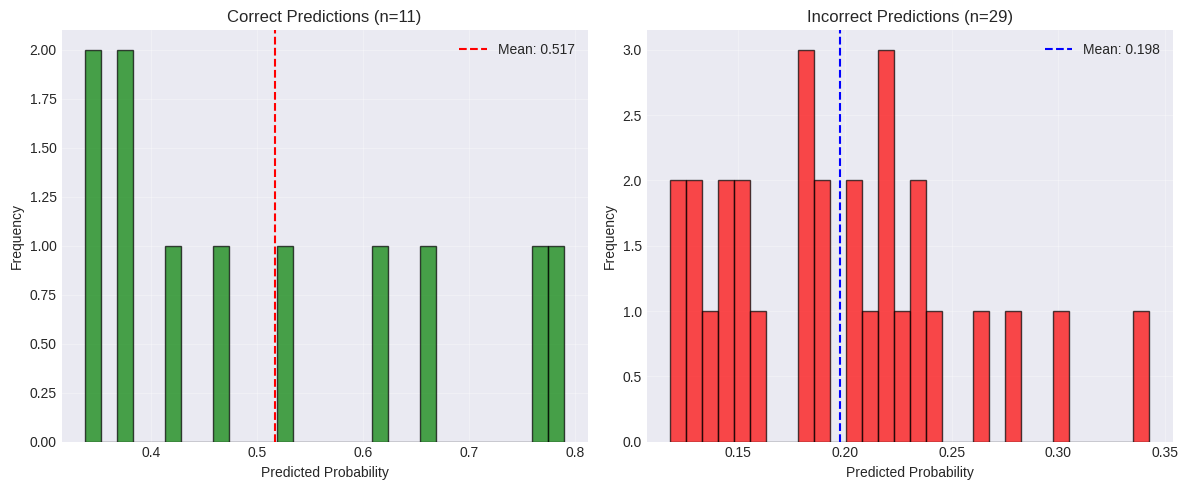


올바른 예측의 평균 확률: 0.5173
잘못된 예측의 평균 확률: 0.1976


In [23]:
# 예측 확률 분포 시각화 (올바른 예측 vs 잘못된 예측)
correct_mask = (y_true == y_pred)
correct_probs = y_pred_prob[correct_mask][np.arange(np.sum(correct_mask)), y_true[correct_mask]]
incorrect_probs = y_pred_prob[~correct_mask][np.arange(np.sum(~correct_mask)), y_true[~correct_mask]]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(correct_probs, bins=30, alpha=0.7, color='green', edgecolor='black')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title(f'Correct Predictions (n={len(correct_probs)})')
plt.axvline(correct_probs.mean(), color='red', linestyle='--', 
           label=f'Mean: {correct_probs.mean():.3f}')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(incorrect_probs, bins=30, alpha=0.7, color='red', edgecolor='black')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title(f'Incorrect Predictions (n={len(incorrect_probs)})')
if len(incorrect_probs) > 0:
    plt.axvline(incorrect_probs.mean(), color='blue', linestyle='--',
               label=f'Mean: {incorrect_probs.mean():.3f}')
    plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../models/prediction_probabilities.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n올바른 예측의 평균 확률: {correct_probs.mean():.4f}")
if len(incorrect_probs) > 0:
    print(f"잘못된 예측의 평균 확률: {incorrect_probs.mean():.4f}")

## 9. 예측 예시 분석

In [24]:
# 랜덤 샘플 예측 분석
n_samples_to_show = 5
sample_indices = np.random.choice(len(X_test), n_samples_to_show, replace=False)

print("\n" + "="*80)
print("예측 샘플 분석")
print("="*80)

for idx in sample_indices:
    true_label = y_true[idx]
    pred_label = y_pred[idx]
    pred_probs = y_pred_prob[idx]
    
    print(f"\n샘플 #{idx}")
    print(f"  실제 클래스: {target_names[true_label]}")
    print(f"  예측 클래스: {target_names[pred_label]}")
    print(f"  예측 확률:")
    for i, (name, prob) in enumerate(zip(target_names, pred_probs)):
        marker = " ← 예측" if i == pred_label else ""
        marker += " (정답)" if i == true_label else ""
        print(f"    {name}: {prob:.4f}{marker}")
    print(f"  결과: {'✓ 정확' if true_label == pred_label else '✗ 오류'}")


예측 샘플 분석

샘플 #6
  실제 클래스: Fault Type 2
  예측 클래스: Fault Type 2
  예측 확률:
    Fault Type 0: 0.1592
    Fault Type 1: 0.2475
    Fault Type 2: 0.3385 ← 예측 (정답)
    Fault Type 3: 0.2549
  결과: ✓ 정확

샘플 #15
  실제 클래스: Fault Type 1
  예측 클래스: Fault Type 1
  예측 확률:
    Fault Type 0: 0.1267
    Fault Type 1: 0.6183 ← 예측 (정답)
    Fault Type 2: 0.1123
    Fault Type 3: 0.1427
  결과: ✓ 정확

샘플 #4
  실제 클래스: Fault Type 2
  예측 클래스: Fault Type 1
  예측 확률:
    Fault Type 0: 0.1535
    Fault Type 1: 0.4222 ← 예측
    Fault Type 2: 0.1851 (정답)
    Fault Type 3: 0.2391
  결과: ✗ 오류

샘플 #0
  실제 클래스: Fault Type 1
  예측 클래스: Fault Type 1
  예측 확률:
    Fault Type 0: 0.0784
    Fault Type 1: 0.6548 ← 예측 (정답)
    Fault Type 2: 0.0614
    Fault Type 3: 0.2053
  결과: ✓ 정확

샘플 #26
  실제 클래스: Fault Type 0
  예측 클래스: Fault Type 3
  예측 확률:
    Fault Type 0: 0.2262 (정답)
    Fault Type 1: 0.2023
    Fault Type 2: 0.1861
    Fault Type 3: 0.3854 ← 예측
  결과: ✗ 오류


## 10. 모델 저장

In [25]:
# 최종 모델 저장
model.save('../models/final_cnn_lstm_model.h5')
print("최종 모델 저장 완료: ../models/final_cnn_lstm_model.h5")

# Scaler 저장 (새로운 데이터 예측 시 필요)
import pickle

with open('../models/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("Scaler 저장 완료: ../models/scaler.pkl")

# 모델 설정 저장
config = {
    'window_size': window_size,
    'stride': stride,
    'n_sensors': X_scaled.shape[1],
    'n_classes': n_classes,
    'target_names': target_names
}

with open('../models/model_config.pkl', 'wb') as f:
    pickle.dump(config, f)
print("모델 설정 저장 완료: ../models/model_config.pkl")

최종 모델 저장 완료: ../models/final_cnn_lstm_model.h5
Scaler 저장 완료: ../models/scaler.pkl
모델 설정 저장 완료: ../models/model_config.pkl


## 11. 모델 로드 및 사용 예시

In [26]:
# 저장된 모델 로드 예시
def load_saved_model():
    """
    저장된 모델과 관련 설정을 로드
    """
    # 모델 로드
    loaded_model = keras.models.load_model('../models/final_cnn_lstm_model.h5')
    
    # Scaler 로드
    with open('../models/scaler.pkl', 'rb') as f:
        loaded_scaler = pickle.load(f)
    
    # 설정 로드
    with open('../models/model_config.pkl', 'rb') as f:
        loaded_config = pickle.load(f)
    
    return loaded_model, loaded_scaler, loaded_config

# 테스트
print("모델 로드 테스트...")
loaded_model, loaded_scaler, loaded_config = load_saved_model()
print("\n모델 로드 성공!")
print(f"설정: {loaded_config}")

모델 로드 테스트...

모델 로드 성공!
설정: {'window_size': 100, 'stride': 50, 'n_sensors': 10, 'n_classes': 4, 'target_names': ['Fault Type 0', 'Fault Type 1', 'Fault Type 2', 'Fault Type 3']}


## 12. 결론 및 개선 방향

### 달성한 결과
- CNN-LSTM 하이브리드 모델을 성공적으로 구현
- 슬라이딩 윈도우를 통한 시계열 데이터 처리
- 고장 유형 분류 모델 학습 및 평가

### 성능 개선 방법

1. **데이터 증강**
   - 시계열 데이터 증강 기법 (jittering, scaling, rotation)
   - SMOTE를 통한 클래스 불균형 해소

2. **하이퍼파라미터 튜닝**
   - 윈도우 크기 최적화
   - LSTM units 수 조정
   - Learning rate 스케줄링

3. **모델 아키텍처 개선**
   - Bidirectional LSTM 사용
   - Attention mechanism 추가
   - Residual connections

4. **앙상블 기법**
   - 여러 모델의 예측을 결합
   - Stacking, Voting 등

5. **전이 학습**
   - 유사한 도메인의 사전 학습된 모델 활용

### 실무 적용 시 고려사항
- 실시간 추론 성능 최적화
- 모델 해석 가능성 (SHAP, GradCAM)
- 지속적인 모델 업데이트 파이프라인
- 엣지 디바이스 배포 (모델 경량화)

In [27]:
# 실습 완료 요약 출력
print("\n" + "="*80)
print("실습 완료 요약")
print("="*80)
print(f"데이터셋 크기: {len(df)} 샘플")
print(f"윈도우 개수: {len(X_windows)} 개")
print(f"학습 데이터: {len(X_train)} 개")
print(f"테스트 데이터: {len(X_test)} 개")
print(f"\n최종 테스트 정확도: {accuracy:.4f}")
print(f"최종 가중 F1-Score: {f1:.4f}")
print("\n저장된 파일:")
print("  - ../models/final_cnn_lstm_model.h5")
print("  - ../models/scaler.pkl")
print("  - ../models/model_config.pkl")
print("  - ../models/training_history.png")
print("  - ../models/confusion_matrix.png")
print("\n수고하셨습니다!")
print("="*80)


실습 완료 요약
데이터셋 크기: 10000 샘플
윈도우 개수: 199 개
학습 데이터: 159 개
테스트 데이터: 40 개

최종 테스트 정확도: 0.2750
최종 가중 F1-Score: 0.2107

저장된 파일:
  - ../models/final_cnn_lstm_model.h5
  - ../models/scaler.pkl
  - ../models/model_config.pkl
  - ../models/training_history.png
  - ../models/confusion_matrix.png

수고하셨습니다!
